
# Diffusion Tube NO₂ — From Absorbance to Concentration (μg/m³)
This student-friendly notebook converts **absorbance (Abs)** to **ambient NO₂ concentration (μg/m³)** and converts **UK OS six‑figure grid references** to **ten‑figure** and **WGS84 latitude/longitude**.

It follows the Excel pipeline used by your supervisor (Box 4‑10):
1. **Abs → C (μg/mL)** via the calibration line.
2. **C × V** → nitrite **mass (μg)** in the cuvette.
3. **mass / t / S.Rate** → NO₂ at **284 K** (μg/m³).
4. **Temperature correction** to **293 K**.

> You only need to edit the **Parameters** cell.



## 0. Requirements (run once)
If `pyproj` is not installed, uncomment the pip line below.


In [1]:

# !pip install pyproj pandas folium
import pandas as pd
from pyproj import Transformer
print("Libraries loaded")


Libraries loaded



## 1. Parameters — change these for your dataset
- `INPUT_PATH`: the raw spreadsheet from class.
- Calibration **Abs = m*C + b**, with **C in μg/mL** from your calibration plot.
- `CUVETTE_VOL_mL`: final colour‑development volume (mL).
- `SRATE_m3_per_h`: sampling rate (m³/h) from the Excel sheet.
- Temperature correction (284 K → 293 K by default).
- OS two‑letter grid (Bristol commonly **ST**).


In [2]:
# ====== EDIT THESE AS NEEDED ======
INPUT_PATH = 'Tube location spreadsheet NO2 data 24_25 origin.xlsx'
SHEET_NAME = 'Sheet1'
HEADER_CONTAINS = 'Group'      # text that appears in the header row

# UK OS grid letters (Bristol commonly 'ST')
GRID_LETTERS = 'ST'

# Calibration: Abs = m*C + b  (C in μg/mL)
CAL_SLOPE_m     = 1.0577
CAL_INTERCEPT_b = 0.0648

# Final colour development volume (mL)
CUVETTE_VOL_mL  = 3.0

# Sampling rate (m^3 per hour)
SRATE_m3_per_h  = 7.03e-05

# Temperature correction: from 284 K to 293 K
TEMP_FROM_K = 284.0
TEMP_TO_K   = 293.0

# Fallback exposure time (hours) if nothing valid exists
FALLBACK_HOURS_IF_ALL_MISSING = 168.0  # 7 days

# Output files
OUTPUT_ALL = 'NO2_processed_output.xlsx'      # per tube
OUTPUT_AVG = 'NO2_site_averaged.xlsx'         # site averages

print("Parameters set")


Parameters set



## 2. Helper functions (no need to edit)
- Keep column names unique.
- Convert OS six‑figure grid → ten‑figure (cell centre) → WGS84 lat/lon using **EPSG:27700 → 4326**.
- Chemistry function implementing the Excel calculation.


In [3]:
import re

def make_unique(seq):
    '''Add .1, .2 to duplicate column names so pandas will not clash.'''
    seen = {}
    out = []
    for x in seq:
        if x not in seen:
            seen[x] = 0; out.append(str(x))
        else:
            seen[x] += 1; out.append(f"{x}.{seen[x]}")
    return out

# OS six‑figure grid -> 10‑figure centre -> WGS84
_transformer = Transformer.from_crs("EPSG:27700","EPSG:4326", always_xy=True)

def _let_idx(ch):
    n = ord(ch) - 65
    return n - 1 if n > 7 else n   # skip 'I'

def _letters_100km(l1, l2):
    L1 = _let_idx(l1); L2 = _let_idx(l2)
    e100km = ((L1 - 2) % 5) * 5 + (L2 % 5)
    n100km = 19 - (L1 // 5) * 5 - (L2 // 5)
    return e100km * 100000, n100km * 100000

def os_to_grid10_latlon(grid_letters, six_digits):
    '''Convert 6‑figure digits to 10‑figure OS grid (centre) and WGS84 lat/lon.'''
    s = re.sub(r'\\s+','',str(six_digits))
    if not s.isdigit() or len(s) < 6:
        raise ValueError(f"Bad six‑figure grid ref: {six_digits}")
    e = int(s[:3]) * 100
    n = int(s[3:]) * 100
    e0, n0 = _letters_100km(grid_letters[0], grid_letters[1])
    E = e0 + e + 50   # centre of cell
    N = n0 + n + 50
    lon, lat = _transformer.transform(E, N)
    grid10 = f"{grid_letters}{str(e).zfill(5)}{str(n).zfill(5)}"
    return grid10, lat, lon

def abs_to_no2_excel(abs_value, hours):
    '''
    Excel‑equivalent chemistry:
    1) C (μg/mL) = (Abs - b) / m
    2) mass (μg) = C * V(mL)
    3) C_284 (μg/m^3) = (mass / t_h) / S.Rate (m^3/h)
    4) C_293 = C_284 * (284/293)
    '''
    if pd.isna(abs_value) or pd.isna(hours) or hours <= 0:
        return None
    C_ug_per_mL = (float(abs_value) - CAL_INTERCEPT_b) / CAL_SLOPE_m
    if C_ug_per_mL < 0:
        C_ug_per_mL = 0.0
    mass_ug = C_ug_per_mL * CUVETTE_VOL_mL
    C_284   = (mass_ug / hours) / SRATE_m3_per_h
    C_293   = C_284 * (TEMP_FROM_K / TEMP_TO_K)
    return max(C_293, 0.0)

print("Helpers ready")


Helpers ready



## 3. Load the raw spreadsheet
We auto‑detect the header row (the one containing **"Group"**) and read the table underneath.


In [4]:
raw = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME, header=None, dtype=str)
hdr = raw.index[raw.apply(lambda r: r.astype(str).str.contains(HEADER_CONTAINS, na=False)).any(axis=1)][0]
cols = make_unique(raw.iloc[hdr].tolist())
df = raw.iloc[hdr+1:].reset_index(drop=True); df.columns = cols
print("Loaded:", df.shape)
df.head(3)


Loaded: (47, 22)


,Group,Grid square,Barcode,Six figure grid ref,Date and time put out,Date and time retrieved,A (542 nm),Barcode.1,Six figure grid ref.1,Date and time put out.1,...,Barcode.2,Six figure grid ref.2,Date and time put out.2,Date and time retrieved.2,A (542 nm).2,Barcode.3,Six figure grid ref.3,Date and time put out.3,Date and time retrieved.3,A (542 nm).3
0,EXAMPLE,5284,UO218,523 842,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,0.XX,NaN,NaN,dd/mm/yyyy hh:mm,...,NaN,NaN,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,NaN,NaN,NaN,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,NaN
1,1,5572,HO118,558727,20/09/2024 11:15,30/10/2024 10:47:00 AM,0.60274,HO218,554726,20/09/2024 11:35,...,HO318,558728,20/09/2024 11:50,2024-10-30 11:17:00,0.22818,HO418,556729,20/09/2024 12:00,2024-10-30 11:22:00,0.2861
2,2,5573,B0318,559730,20/09/2024 14:28,2024-03-11 14:06:00,0.21875,B0118,553730,20/09/2024 14:40,...,B0218,554731,20/09/2024 14:50,2024-03-11 14:42:00,0.23218,B0418,556732,20/09/2024 14:58,2024-03-11 15:07:00,0.19442



## 4. Expand repeating tube blocks (Barcode → A(542 nm))
The template contains 4 repeating tube sections (Tube 1–4). We find each block by the first column named **`Barcode`** and end at **`A (542 nm)`**, then stack them into a long table.


In [5]:
base_cols = [c for c in cols if str(c).strip() in ['Group','Grid square']]
starts    = [i for i, name in enumerate(cols) if str(name).startswith('Barcode')]

rows = []
for period, s in enumerate(starts, start=1):
    e = next((i for i in range(s, len(cols)) if str(cols[i]).startswith('A (542 nm)')), None)
    if e is None:
        continue
    pos_base = [cols.index(c) for c in base_cols]     # IMPORTANT: iloc by position
    sub = df.iloc[:, pos_base + list(range(s, e+1))].copy()
    sub.columns = base_cols + ['Barcode','Six figure grid ref','Date out','Date retrieved','Abs']
    sub['period'] = period
    rows.append(sub)

tidy = pd.concat(rows, ignore_index=True)
print("Tidy (per‑tube) rows:", len(tidy))
tidy.head(6)


Tidy (per‑tube) rows: 188


,Group,Grid square,Barcode,Six figure grid ref,Date out,Date retrieved,Abs,period
0,EXAMPLE,5284,UO218,523 842,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,0.XX,1
1,1,5572,HO118,558727,20/09/2024 11:15,30/10/2024 10:47:00 AM,0.60274,1
2,2,5573,B0318,559730,20/09/2024 14:28,2024-03-11 14:06:00,0.21875,1
3,3,5574,A1118,559 749,21/09/2024 12:48,2024-02-11 13:48:00,1.73827,1
4,4,5575,P0118,557 750,25/09/2024 10:44,2024-05-11 08:42:00,0.29099,1
5,5,5576,D0418,557 764,2024-09-25 11:10:00,2024-03-11 13:28:00,0.33785,1



## 5. Exposure time `t` (hours) with QC and sensible defaults
We compute `t_hours` from **Date out → Date retrieved** (day‑first).  
Then we apply **sanity bounds** (300–800 h) and replace missing/abnormal values with the **median of valid times** (or 168 h if nothing is valid).


In [6]:
t_out = pd.to_datetime(tidy['Date out'], errors='coerce', dayfirst=True)
t_ret = pd.to_datetime(tidy['Date retrieved'], errors='coerce', dayfirst=True)
tidy['t_hours'] = (t_ret - t_out).dt.total_seconds() / 3600.0

print("Exposure time (h) before QC:\n", tidy['t_hours'].describe())

LOWER_H, UPPER_H = 300.0, 800.0
TARGET_H = 650.0

median_valid = tidy.loc[tidy['t_hours'].between(LOWER_H, UPPER_H), 't_hours'].median()
if pd.isna(median_valid):
    median_valid = TARGET_H

tidy['t_hours'] = pd.to_numeric(tidy['t_hours'], errors='coerce')
mask_bad_time = tidy['t_hours'].isna() | (tidy['t_hours'] <= 0) | (tidy['t_hours'] < LOWER_H) | (tidy['t_hours'] > UPPER_H)
tidy.loc[mask_bad_time, 't_hours'] = median_valid
tidy['t_hours'] = tidy['t_hours'].fillna(FALLBACK_HOURS_IF_ALL_MISSING)

print(f"Replaced abnormal times: {int(mask_bad_time.sum())} row(s). Using median valid = {median_valid:.1f} h")
tidy[['Date out','Date retrieved','t_hours']].head(6)


Exposure time (h) before QC:
 count       160.000000
mean       -581.842396
std       14411.342013
min       -6189.600000
25%       -4747.650000
50%       -3143.466667
75%         936.504167
max      124713.850000
Name: t_hours, dtype: float64
Replaced abnormal times: 179 row(s). Using median valid = 748.5 h


/var/folders/9_/5q13t_9x3_33x0nxsk6kgzyw0000gn/T/ipykernel_5202/1459701545.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t_out = pd.to_datetime(tidy['Date out'], errors='coerce', dayfirst=True)
/var/folders/9_/5q13t_9x3_33x0nxsk6kgzyw0000gn/T/ipykernel_5202/1459701545.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t_ret = pd.to_datetime(tidy['Date retrieved'], errors='coerce', dayfirst=True)


,Date out,Date retrieved,t_hours
0,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,748.5
1,20/09/2024 11:15,30/10/2024 10:47:00 AM,748.5
2,20/09/2024 14:28,2024-03-11 14:06:00,748.5
3,21/09/2024 12:48,2024-02-11 13:48:00,748.5
4,25/09/2024 10:44,2024-05-11 08:42:00,748.5
5,2024-09-25 11:10:00,2024-03-11 13:28:00,748.5



## 6. Coordinates from OS six‑figure grid (assuming two‑letter `'ST'`)
We convert to **10‑figure** grid (centre of cell) and **WGS84 lat/lon**.  
If your file already contains latitude/longitude, you can replace the computed values.


In [8]:
g10_list, lat_list, lon_list = [], [], []
for digits in tidy['Six figure grid ref'].astype(str):
    digits_clean = digits.replace(" ", "") 
    try:
        g10, la, lo = os_to_grid10_latlon(GRID_LETTERS, digits_clean)
    except Exception:
        g10 = la = lo = None
    g10_list.append(g10); lat_list.append(la); lon_list.append(lo)

tidy['Grid_ref_10fig'] = g10_list
tidy['Lat_WGS84']      = pd.to_numeric(pd.Series(lat_list), errors='coerce')
tidy['Lon_WGS84']      = pd.to_numeric(pd.Series(lon_list), errors='coerce')
tidy[['Grid_ref_10fig','Lat_WGS84','Lon_WGS84']].head(6)


,Grid_ref_10fig,Lat_WGS84,Lon_WGS84
0,ST5230084200,51.555111,-2.688680
1,ST5580072700,51.452001,-2.636758
2,ST5590073000,51.454706,-2.635356
3,ST5590074900,51.471789,-2.635594
4,ST5570075000,51.472673,-2.638485
5,ST5570076400,51.485260,-2.638661



## 7. Chemistry: Abs → NO₂ (μg/m³) per tube
We implement the Excel method exactly and add sensible defaults: **missing Abs → 0**.


In [9]:
tidy['Abs'] = pd.to_numeric(tidy['Abs'], errors='coerce').fillna(0.0)
tidy['NO2_ug_per_m3'] = tidy.apply(lambda r: abs_to_no2_excel(r['Abs'], r['t_hours']), axis=1)
tidy[['Grid_ref_10fig','Abs','t_hours','NO2_ug_per_m3']].head(8)


,Grid_ref_10fig,Abs,t_hours,NO2_ug_per_m3
0,ST5230084200,0.00000,748.5,0.000000
1,ST5580072700,0.60274,748.5,28.105815
2,ST5590073000,0.21875,748.5,8.043444
3,ST5590074900,1.73827,748.5,87.433985
4,ST5570075000,0.29099,748.5,11.817776
5,ST5570076400,0.33785,748.5,14.266076
6,ST5690072100,0.33144,748.5,13.931172
7,ST5670073200,0.33111,748.5,13.913930



## 8. Save per‑tube results


In [10]:

tidy.to_excel(OUTPUT_ALL, index=False)
print("Saved per‑tube results to", OUTPUT_ALL)


Saved per‑tube results to NO2_processed_output.xlsx


In [11]:
# Save the concentration data of longitude and latitude for each tube
per_tube_output = tidy[['Lat_WGS84', 'Lon_WGS84', 'NO2_ug_per_m3']].copy()

per_tube_output.head(10)

# Save as excel
per_tube_output.to_excel('NO2_per_tube_output.xlsx', index=False)
print("Saved per-tube NO2 data to NO2_per_tube_output.xlsx")


,Lat_WGS84,Lon_WGS84,NO2_ug_per_m3
0,51.555111,-2.688680,0.000000
1,51.452001,-2.636758,28.105815
2,51.454706,-2.635356,8.043444
3,51.471789,-2.635594,87.433985
4,51.472673,-2.638485,11.817776
5,51.485260,-2.638661,14.266076
6,51.446691,-2.620855,13.931172
7,51.456566,-2.623868,13.913930
8,51.471866,-2.621197,15.187715
9,51.478137,-2.625602,9.191313



## 9. Quick scatter map (approximate)
This is a quick look. For publication‑quality maps, use Folium or GIS.


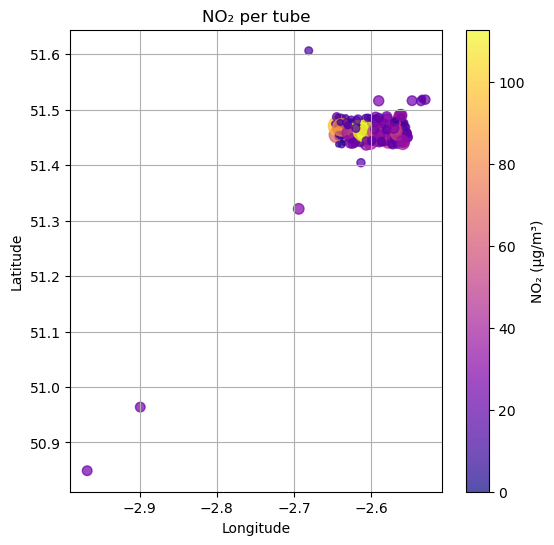

In [13]:
import matplotlib.pyplot as plt

filtered = per_tube_output.dropna(subset=['Lat_WGS84','Lon_WGS84','NO2_ug_per_m3'])

plt.figure(figsize=(6,6))
plt.scatter(
    filtered['Lon_WGS84'],
    filtered['Lat_WGS84'],
    s=filtered['NO2_ug_per_m3']*2,  
    alpha=0.7,
    c=filtered['NO2_ug_per_m3'],
    cmap='plasma'
)
plt.colorbar(label='NO₂ (μg/m³)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NO₂ per tube')
plt.grid(True)
plt.show()




## 10. Optional interactive map (Folium)
Uncomment the `pip` line at the top if Folium is missing.


In [15]:
import folium
import branca.colormap as cm

# Obtain the concentration range
filtered = per_tube_output.dropna(subset=['Lat_WGS84','Lon_WGS84','NO2_ug_per_m3'])
min_no2 = filtered['NO2_ug_per_m3'].min()
max_no2 = filtered['NO2_ug_per_m3'].max()

# Generate color mapping
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'],
                             vmin=min_no2, vmax=max_no2,
                             caption='NO₂ Concentration (μg/m³)')

# Create map
m = folium.Map(location=[51.455, -2.6], zoom_start=12)

# Create point
for _, r in filtered.iterrows():
    value = r['NO2_ug_per_m3']
    color = colormap(value)
    folium.CircleMarker(
        location=[r['Lat_WGS84'], r['Lon_WGS84']],
        radius=max(value / 5, 3),
        popup=f"{value:.1f} μg/m³",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

colormap.add_to(m)

# Show map in Jupyter
m



## 12. Re‑use next year
- Update the **Parameters** cell (calibration, volume, rate, temperatures).
- Point `INPUT_PATH` to the new spreadsheet.
- Run the notebook from top to bottom.
- If you already have Latitude/Longitude columns, replace the computed ones after Step 6.
